In [7]:
import torch
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
for dirname, _, filenames in os.walk('/content/drive/MyDrive/NLP_243'): # change the path to your own path
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NLP_243/hw2_train.csv
/content/drive/MyDrive/NLP_243/hw2_test.csv
/content/drive/MyDrive/NLP_243/val.csv
/content/drive/MyDrive/NLP_243/train.csv
/content/drive/MyDrive/NLP_243/submit.csv
/content/drive/MyDrive/NLP_243/result.csv
/content/drive/MyDrive/NLP_243/BiLstm.ipynb
/content/drive/MyDrive/NLP_243/train.txt
/content/drive/MyDrive/NLP_243/test.txt
/content/drive/MyDrive/NLP_243/validation.txt
/content/drive/MyDrive/NLP_243/Language Modeling.ipynb
/content/drive/MyDrive/NLP_243/model.pt
/content/drive/MyDrive/NLP_243/RNN language modeling.ipynb
/content/drive/MyDrive/NLP_243/Slot Tagging.ipynb
/content/drive/MyDrive/NLP_243/CommitmentBank-items.csv
/content/drive/MyDrive/NLP_243/CommitmentBank-All.csv
/content/drive/MyDrive/NLP_243/Project.gdoc
/content/drive/MyDrive/NLP_243/Data prepare and exploration.ipynb
/content/drive/MyDrive/

In [8]:
data = pd.read_csv('/content/drive/MyDrive/NLP_243/CommitmentBank-items.csv')
data

,Unnamed: 0,uID,Verb,Embedding,Context,Target,Prompt,ModalType,MatTense,MatSubjLemma,MatSubjPer,MatSubjNum,Embedding.1,genre,factive,mean.noTarget,sd.noTarget,Mean,SD,Reponses
0,1,BNC-1,admit,conditional,Polly had to think quickly.,They were still close enough to shore for him ...,Polly was not an experienced ocean sailor,NaN,future,she,third,singular,conditional,BNC,no,-0.111111,1.269296,2.000000,0.866025,"2, 3, 3, 1, 3, 1, 2, 1, 2"
1,2,BNC-1002,say,modal,"Nevertheless, life went on as it always does. ...",Indeed it could be said that they had prospered.,the Kiwi Keith and the Mackenzie houses had pr...,CI,present,it,third,singular,modal,BNC,no,1.200000,1.873796,1.875000,0.834523,"2, 1, 3, 1, 2, 2, 3, 1"
2,3,BNC-1003,say,modal,"He patted her hand. If he had chosen to, Thoma...",He might have said to her that some time in th...,some time in the middle of the nineteenth cent...,AB,present,he,third,singular,modal,BNC,no,-0.250000,0.462910,0.666667,1.154701,"2, 0, 1, 0, 0, 3, -1, 0, 1, 0, 0, 2"
3,4,BNC-1005,say,modal,She could see his distorted image in the slant...,Of course she could say it was for the childre...,it was for the children,AB,future,she,third,singular,modal,BNC,no,0.636364,1.120065,0.875000,0.991031,"2, 1, 0, 1, -1, 1, 1, 2"
4,5,BNC-1006,say,modal,"She glanced around the room, laying her hot fl...",Robyn swallowed and took a deep breath trying ...,it was all right,AB,future,she,third,singular,modal,BNC,no,-1.090909,1.044466,0.000000,2.309401,"3, 1, -2, -3, -3, 3, 2, 1, -1, -1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1196,WSJ-95,feel,negation,"Across the board, these consumers value qualit...",Twenty percent don't even feel they are financ...,they are financially well off,NaN,present,twenty percent,third,plural,negation,WSJ,no,-1.750000,1.035098,-1.000000,2.371708,"-2, 3, -3, -3, -2, -3, -3, 2, -3, -1, 3, -3, 0..."
1196,1197,WSJ-96,mean,negation,The Fed has assumed a similar responsibility i...,This does not mean that the Federal Reserve do...,the Federal Reserve does not already play an i...,NaN,present,this,third,singular,negation,WSJ,no,-0.722222,1.964555,0.125000,2.028957,"2, -2, 3, 0, 2, 1, 2, -2, 2, 1, -1, 0, -2, -3,..."
1197,1198,WSJ-97,expect,modal,Under the Racketeer Influenced and Corrupt Org...,"In a letter, prosecutors told Mr. Antar's lawy...",any fees collected from Mr. Antar may be seized,AB,present,they,third,plural,modal,WSJ,no,1.600000,1.264911,2.058824,1.477777,"1, 3, -3, 3, 3, 3, 2, 2, 1, 2, 2, 3, 2, 2, 3, ..."
1198,1199,WSJ-98,believe,negation,"Talks between the two sides could unravel, of ...",And although Warner has said it wanted the pro...,the relationship could be repaired after the a...,NaN,present,they,third,plural,negation,WSJ,no,1.083333,1.378954,-1.733333,1.751190,"-1, -3, -3, -1, -2, 1, -3, -3, -3, -3, 2, -2, ..."


In [9]:
from pandas.core.arrays import categorical

# now try to category the mean score the -1, 0, 1
def get_categorize_score(data):
  categorize_score = []
  # data.insert(data.shape[1], 'd', 0)
  for i in range(len(data)):
  # we categorize [-3,-1) to -1, represent the negative
    if data.iloc[i]['Mean'] >= -3 and data.iloc[i]['Mean'] < -1:
       categorize_score.append(-1)
  # [-1,1) to 0, represent uncertain
    if data.iloc[i]['Mean'] >= -1 and data.iloc[i]['Mean'] < 1:
      categorize_score.append(0)
  # [1,3] to 1, represent right
    if data.iloc[i]['Mean'] <= 3 and data.iloc[i]['Mean'] >= 1:
      categorize_score.append(1)
  data.insert(data.shape[1], 'categorize_score', categorize_score)
  return data

data = get_categorize_score(data)

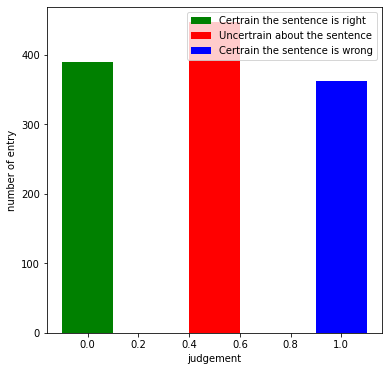

In [10]:
def plot_counts(train_good,train_bad, train_neu):
    plt.rcParams['figure.figsize']=(6,6) 
    plt.bar(0,train_good,width=0.2,label='Certrain the sentence is right',color='Green')
    plt.legend()
    plt.bar(0.5,train_bad,width=0.2,label='Uncertrain about the sentence',color='Red')
    plt.legend()
    plt.bar(1.0,train_neu,width=0.2,label='Certrain the sentence is wrong',color='Blue')
    plt.legend()
    plt.ylabel('number of entry')
    plt.xlabel('judgement')
    plt.show()

right=data[data['categorize_score']==1]
uncertain=data[data['categorize_score']==0]
wrong = data[data['categorize_score']==-1]
plot_counts(len(right), len(uncertain), len(wrong))

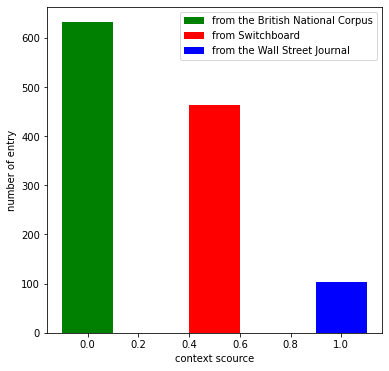

In [11]:
def scource_distribution(data):
  BNC = SWBD = WSJ = 0
  for i in range(len(data)):
    if 'BNC' in data.iloc[i]['uID']:
      BNC += 1
    elif 'SWBD' in data.iloc[i]['uID']:
      SWBD += 1
    elif 'WSJ' in data.iloc[i]['uID']:
      WSJ += 1
  plt.rcParams['figure.figsize']=(6,6) 
  plt.bar(0,BNC,width=0.2,label='from the British National Corpus',color='Green')
  plt.legend()
  plt.bar(0.5,SWBD,width=0.2,label='from Switchboard',color='Red')
  plt.legend()
  plt.bar(1.0,WSJ,width=0.2,label='from the Wall Street Journal',color='Blue')
  plt.legend()
  plt.ylabel('number of entry')
  plt.xlabel('context scource')
  plt.show()

scource_distribution(data)

In [12]:
def get_All_Text(data):
  All_Text = []
  for i in range(len(data)):
    text = str(data.iloc[i]['Context']) + str(data.iloc[i]['Target']) + str(data.iloc[i]['Prompt'])
    All_Text.append(text)
  data.insert(data.shape[1], 'All_Text', All_Text)
  return data

data = get_All_Text(data)
data

,Unnamed: 0,uID,Verb,Embedding,Context,Target,Prompt,ModalType,MatTense,MatSubjLemma,...,Embedding.1,genre,factive,mean.noTarget,sd.noTarget,Mean,SD,Reponses,categorize_score,All_Text
0,1,BNC-1,admit,conditional,Polly had to think quickly.,They were still close enough to shore for him ...,Polly was not an experienced ocean sailor,NaN,future,she,...,conditional,BNC,no,-0.111111,1.269296,2.000000,0.866025,"2, 3, 3, 1, 3, 1, 2, 1, 2",1,Polly had to think quickly.They were still clo...
1,2,BNC-1002,say,modal,"Nevertheless, life went on as it always does. ...",Indeed it could be said that they had prospered.,the Kiwi Keith and the Mackenzie houses had pr...,CI,present,it,...,modal,BNC,no,1.200000,1.873796,1.875000,0.834523,"2, 1, 3, 1, 2, 2, 3, 1",1,"Nevertheless, life went on as it always does. ..."
2,3,BNC-1003,say,modal,"He patted her hand. If he had chosen to, Thoma...",He might have said to her that some time in th...,some time in the middle of the nineteenth cent...,AB,present,he,...,modal,BNC,no,-0.250000,0.462910,0.666667,1.154701,"2, 0, 1, 0, 0, 3, -1, 0, 1, 0, 0, 2",0,"He patted her hand. If he had chosen to, Thoma..."
3,4,BNC-1005,say,modal,She could see his distorted image in the slant...,Of course she could say it was for the childre...,it was for the children,AB,future,she,...,modal,BNC,no,0.636364,1.120065,0.875000,0.991031,"2, 1, 0, 1, -1, 1, 1, 2",0,She could see his distorted image in the slant...
4,5,BNC-1006,say,modal,"She glanced around the room, laying her hot fl...",Robyn swallowed and took a deep breath trying ...,it was all right,AB,future,she,...,modal,BNC,no,-1.090909,1.044466,0.000000,2.309401,"3, 1, -2, -3, -3, 3, 2, 1, -1, -1",0,"She glanced around the room, laying her hot fl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1196,WSJ-95,feel,negation,"Across the board, these consumers value qualit...",Twenty percent don't even feel they are financ...,they are financially well off,NaN,present,twenty percent,...,negation,WSJ,no,-1.750000,1.035098,-1.000000,2.371708,"-2, 3, -3, -3, -2, -3, -3, 2, -3, -1, 3, -3, 0...",0,"Across the board, these consumers value qualit..."
1196,1197,WSJ-96,mean,negation,The Fed has assumed a similar responsibility i...,This does not mean that the Federal Reserve do...,the Federal Reserve does not already play an i...,NaN,present,this,...,negation,WSJ,no,-0.722222,1.964555,0.125000,2.028957,"2, -2, 3, 0, 2, 1, 2, -2, 2, 1, -1, 0, -2, -3,...",0,The Fed has assumed a similar responsibility i...
1197,1198,WSJ-97,expect,modal,Under the Racketeer Influenced and Corrupt Org...,"In a letter, prosecutors told Mr. Antar's lawy...",any fees collected from Mr. Antar may be seized,AB,present,they,...,modal,WSJ,no,1.600000,1.264911,2.058824,1.477777,"1, 3, -3, 3, 3, 3, 2, 2, 1, 2, 2, 3, 2, 2, 3, ...",1,Under the Racketeer Influenced and Corrupt Org...
1198,1199,WSJ-98,believe,negation,"Talks between the two sides could unravel, of ...",And although Warner has said it wanted the pro...,the relationship could be repaired after the a...,NaN,present,they,...,negation,WSJ,no,1.083333,1.378954,-1.733333,1.751190,"-1, -3, -3, -1, -2, 1, -3, -3, -3, -3, 2, -2, ...",-1,"Talks between the two sides could unravel, of ..."
